In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, sys, pickle, time, re, csv

In [2]:
Data_folder='C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/' 
##replace this
'Data is here: https://drive.google.com/drive/folders/1vJw8AVZmHQrUnvqkASUwAd4t549uKN6b'

'Data is here: https://drive.google.com/drive/folders/1vJw8AVZmHQrUnvqkASUwAd4t549uKN6b'

In [3]:
'''
####################
###Data structure###
####################


##Neuron npy files:
These contain the normalized firing rates of each neuron - spikes per frame (frame rate is 60 Hz)

npy files for each session
matrix with dimensions [neuron,trial,bin]

360 bins per trial, every state is 90 bins

##Location npy files:
These contain the location of the animal in each bin (should correspond exactly to the neuron bins)
locations1-9 are the 9 nodes

Then the remaining locations 10-21 are the bridges, coded in the "Edge_grid" array. just subtract 10 and that
gives you the index of the Edge_grid array which tells you which bridges are being referenced
e.g. an entry of 10 means index 0 which is array([1, 2]) (i.e. animal is at the the bridge between nodes 1 and 2)

##task_data
this is the task sequence used for that day (which nodes are rewarded in what order)


#####Raw data:

Neuron_raw arrays are matrices of shape neurons X bins
each bin is the firing rate in a 25 ms timewindow

Location_raw arrays are arrays of length equal to the number of bins for the Neuron_raw matrix (may be 1 off)

trialtimes arrays are times (in ms) of each state: the first four columns are the start of each state
the fifth column is the end of the last state (D)

Note that you'll have to convert the trial times from ms to bin number to subset the neuron and location arrays 
(i.e. divide by 25)

'''

'\n####################\n###Data structure###\n####################\n\n\n##Neuron npy files:\nThese contain the normalized firing rates of each neuron - spikes per frame (frame rate is 60 Hz)\n\nnpy files for each session\nmatrix with dimensions [neuron,trial,bin]\n\n360 bins per trial, every state is 90 bins\n\n##Location npy files:\nThese contain the location of the animal in each bin (should correspond exactly to the neuron bins)\nlocations1-9 are the 9 nodes\n\nThen the remaining locations 10-21 are the bridges, coded in the "Edge_grid" array. just subtract 10 and that\ngives you the index of the Edge_grid array which tells you which bridges are being referenced\ne.g. an entry of 10 means index 0 which is array([1, 2]) (i.e. animal is at the the bridge between nodes 1 and 2)\n\n##task_data\nthis is the task sequence used for that day (which nodes are rewarded in what order)\n\n'

In [4]:
##Recording days used
'''These are pairs of days which were spike sorted together to give a total of 6 tasks: animals do 3 tasks a day'''

Recording_days=np.load(Data_folder+'Recording_days_combined.npy')
Recording_days

array(['ah03_18082021_19082021', 'ah04_01122021_02122021',
       'ah04_05122021_06122021', 'ah04_09122021_10122021',
       'me08_10092021_11092021', 'me10_09122021_10122021',
       'me11_01122021_02122021', 'me11_05122021_06122021'], dtype='<U22')

In [5]:
##example task array
mouse_recday='me11_05122021_06122021'
Tasks=np.load(Data_folder+'Task_data_'+mouse_recday+'.npy')

Tasks

array([[7, 4, 3, 5],
       [3, 2, 6, 9],
       [4, 8, 9, 7],
       [7, 4, 3, 8],
       [1, 7, 3, 5],
       [6, 8, 2, 7],
       [6, 8, 2, 7],
       [9, 1, 4, 6],
       [1, 7, 3, 5]])

In [6]:
#Edge grid
'''use this to make sense of the location arrays (see data structure above)'''
Edge_grid=np.load(Data_folder+'Edge_grid.npy')
Edge_grid

array([[1, 2],
       [2, 3],
       [1, 4],
       [2, 5],
       [3, 6],
       [4, 5],
       [5, 6],
       [4, 7],
       [5, 8],
       [6, 9],
       [7, 8],
       [8, 9]])

In [7]:
##Example Location array

mouse_recday='me11_05122021_06122021'
session=0
location_=np.load(Data_folder+'Location_'+mouse_recday+'_'+str(session)+'.npy')

print(np.shape(location_))
location_[0]

(37, 360)


array([ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
       20.,  8.,  8.,  8.,  8., 18.,  5.,  5.,  5., 16.,  6.,  6.,  6.,
       14.,  3.,  3.,  3., 11.,  2.,  2.,  2., 10.,  1.,  1.,  1., 12.,
        4.,  4.,  4., 15.,  5.,  5.,  5., 18.,  8.,  8.,  8.,  8.,  8.,
       21.,  9.,  9., 19., 19.,  6.,  6.,  6., 16.,  5.,  5.,  5., 13.,
        2.,  2.,  2., 11.,  3.,  3.,  3., 14.,  6.,  6.,  6., 16.,  5.,
        5., 18.,  8.,  8.,  8.,  8., 20.,  7.,  7.,  7., 17.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4., 15., 15., 15.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5., 13., 13.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2., 11., 11., 11.,  3.,  3.,  3.,  3

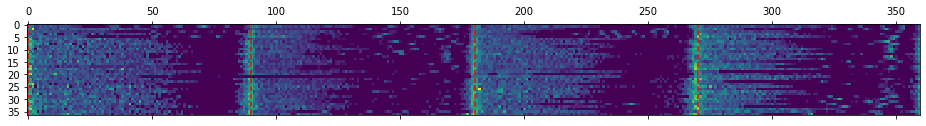

(37, 360)


In [31]:
##Example Neuron activity
mouse_recday='me11_05122021_06122021'
session=0
neuron=0

data_neurons=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
data_neuron=data_neurons[neuron]

plt.matshow(data_neuron)
for angle in np.arange(4)*90:
    plt.axvline(angle,color='red',ls='dashed')
plt.show()

print(np.shape(data_neuron))

In [19]:
data_neuron

array([[0.63157895, 0.63157895, 0.52631579, ..., 0.2       , 0.4       ,
        0.66666667],
       [0.875     , 1.        , 1.        , ..., 0.        , 0.25      ,
        0.625     ],
       [1.        , 1.        , 2.25      , ..., 0.        , 0.33333333,
        0.88888889],
       ...,
       [1.        , 2.        , 1.        , ..., 0.        , 0.75      ,
        0.75      ],
       [0.66666667, 1.        , 1.5       , ..., 0.75      , 1.        ,
        1.25      ],
       [1.5       , 1.33333333, 1.        , ..., 0.        , 0.33333333,
        1.14285714]])

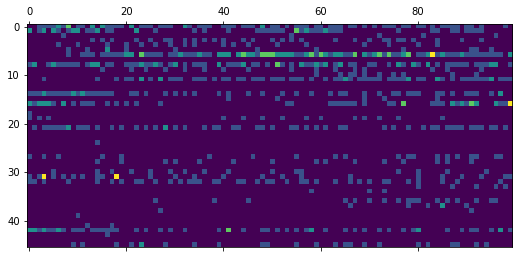

In [12]:
##Example raw neuron activity
mouse_recday='me11_05122021_06122021'
session=0
Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
plt.matshow(Neuron_raw[:,:100])

In [13]:
##Example raw location
mouse_recday='me11_05122021_06122021'
session=0
Location_raw=np.load(Data_folder+'Location_raw_'+mouse_recday+'_'+str(session)+'.npy')
print(Location_raw)

[7. 7. 7. ... 3. 3. 3.]


In [14]:
##Example raw trial times
mouse_recday='me11_05122021_06122021'
session=0
Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
print(Trial_times)

[[      0   28281   37530   52913   60444]
 [  60444   71109   82048   88885  100746]
 [ 100746  105880  120191  128263  141746]
 [ 141746  158295  165093  180260  191678]
 [ 191678  195225  205526  220191  225980]
 [ 225980  236466  245755  264650  273200]
 [ 273200  277549  290244  297799  306116]
 [ 306116  310499  320357  326988  333894]
 [ 333894  338003  351410  357431  365823]
 [ 365823  371263  378970  388377  395136]
 [ 395136  399503  407190  412171  419973]
 [ 419973  425610  434328  440071  447185]
 [ 447185  451190  461302  466944  471890]
 [ 471890  476901  483760  490162  496769]
 [ 496769  502656  509776  515424  522801]
 [ 522801  526872  533576  538595  549444]
 [ 549444  555895  565699  574145  583270]
 [ 583270  589264  600183  607608  615943]
 [ 615943  620412  629838  639555  647759]
 [ 647759  656179  668115  676404  689173]
 [ 689173  694265  700799  717032  730565]
 [ 730565  739107  756527  765340  771537]
 [ 771537  775450  782676  787701  794116]
 [ 794116  